In [1]:
## notebook to generate the figures for the paper
import numpy as np
import matplotlib.pyplot as plt
from natsort import natsorted
import bead_utils as bu
import os, glob, re, importlib, numbers
import scipy.optimize as opt
import scipy.signal as sig
from matplotlib.backends.backend_pdf import PdfPages
from scipy.ndimage import gaussian_filter1d
from matplotlib.patches import Rectangle


First the figure for the charge changes over time

In [2]:
file_label = "20231009"
code_path = "/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/decay_analysis"
data_dir = os.path.join(code_path, "data", file_label)
charge_data = np.load(data_dir+"/charge_data_%s.npz"%file_label)
for k in charge_data.keys():
    exec("%s = charge_data['%s']"%(k,k))

In [3]:
## fit half-life
def lfun(t, N0, t12, tot_time=tot_livetime, use_norm=True, dead_period_edges=all_bad_periods):
    tint = np.linspace(0, tot_time, 1000)
    norm = np.trapz(0.5**(tint/t12), tint)
    if(use_norm):
        val = 1/norm * 0.5**(t/t12)
    else:
        val = N0 * 0.5**(t/t12)
    bad_pts = np.zeros_like(t)
    for dp in dead_period_edges:
        inrange = ((t > dp[0]) & (t < dp[1]))
        bad_pts = np.logical_or(bad_pts, inrange)
    val[bad_pts] = 0
    return val

def nll(t, N0, t12, tot_time=tot_livetime):
    N = len(t)
    mu = N0*(1 - 0.5**(tot_time/t12))
    poiss = N*np.log(mu) - mu
    return -np.sum(np.log(lfun(t, 1, t12))) - poiss

## time of decays/half life
decay_times = good_change_list[:,0] #time_hours[1:][changes]
#big_decay_times = time_hours[1:][big_changes]

## likelihood fit
N0_vec = np.linspace(0, 150, 210)
t12_vec = np.linspace(0.5, 25, 200)
nll_mat_all = np.zeros((len(N0_vec), len(t12_vec)))
#nll_mat_big = np.zeros((len(N0_vec), len(t12_vec)))

for i,N0 in enumerate(N0_vec):
    for j,t12 in enumerate(t12_vec):
        nll_mat_all[i,j] = nll(decay_times, N0, t12)
        #nll_mat_big[i,j] = nll(big_decay_times, N0, t12)

nll_mat_all -= np.min(nll_mat_all)
#nll_mat_big -= np.min(nll_mat_big)

t12_true = 10.6 ## https://www.nndc.bnl.gov/nudat3/DecayRadiationServlet?nuc=212Pb&unc=NDS

nlls = [nll_mat_all,] # nll_mat_big]
labs = ["Fit to all reconstructed decays", "Fit to decays $>6$ $e$"]

params_from_profile = []
for j in range(1):
    
    N0_mesh, t12_mesh = np.meshgrid(N0_vec, t12_vec)
    profile = np.zeros_like(t12_vec)
    profile_nll = np.zeros_like(t12_vec)
    for k in range(len(t12_vec)):
        profile[k] = N0_vec[np.argmin(nlls[j][:,k])]
        profile_nll[k] = 2*np.min(nlls[j][:,k])

    cup = np.where((profile_nll <= 1) & (np.roll(profile_nll,-1) > 1))[0]
    clo = np.where((profile_nll <= 1) & (np.roll(profile_nll,1) > 1))[0]
    cv, uv, lv = t12_vec[np.argmin(profile_nll)], t12_vec[cup], t12_vec[clo]
    min_loc = np.argmin(nlls[j].T)
    bpN0, bpt12 = np.ndarray.flatten(N0_mesh)[min_loc], np.ndarray.flatten(t12_mesh)[min_loc]
    bpN0_lo, bpt12_lo = profile[clo], t12_vec[clo]
    bpN0_hi, bpt12_hi = profile[cup], t12_vec[cup]
    params_from_profile.append([bpN0, bpt12, bpN0_lo, bpt12_lo, bpN0_hi, bpt12_hi])

nbins = 20 #int(tot_livetime/3) + 2

decay_times_list = [decay_times,] # big_decay_times]

for j in range(1):
    hh,be = np.histogram(decay_times_list[j], bins=nbins, range=(0,int(time_hours[-1])))
    bc = be[:-1] + np.diff(be)/2

    bin_length = be[1]-be[0]

/var/folders/sz/h29lm_2j53v8vmw0zm_6hxqm0000gn/T/ipykernel_16417/2707668208.py:19: RuntimeWarning: divide by zero encountered in log
  poiss = N*np.log(mu) - mu


/var/folders/sz/h29lm_2j53v8vmw0zm_6hxqm0000gn/T/ipykernel_16417/505892383.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  inset_ax.set_xticklabels(['2.0', '', '2.5', '', '3.0'])


best fit is:  [62.44019138755981, 12.07286432160804, array([61.72248804]), array([10.47236181]), array([63.87559809]), array([14.28894472])]


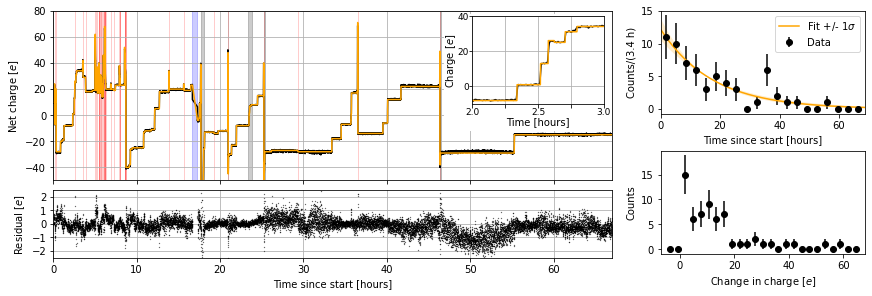

In [4]:
importlib.reload(bu)
recal = 1
init_charge = 10
fig = plt.figure(layout='constrained', figsize=(12, 4))
subfigs = fig.subfigures(1, 2, wspace=0.02, width_ratios=[2.5,1], hspace=0)
n_resamp = 2

axsLeft = subfigs[0].subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [2.5, 1], 'hspace': 0, 'wspace': 0})
#plt.subplot(2,1,1)
#plt.plot(corr_vec[1:,1]/cal_fac*recal, '-')
t12 = 10.6
xv1, xv2 = 0, 67 #time_vals[-1]
time_vals = time_hours[1:]
#diff_vec = np.gradient(corr_vec[1:,corr_idx]/cal_fac)
#b, a = sig.butter(3, 0.000101, btype='high')
#diff_vec = sig.filtfilt(b, a, diff_vec)
#filt_vec = np.cumsum(diff_vec) + init_charge
filt_vec = corr_vec[1:,corr_idx]/cal_fac


filt_vec2 = gaussian_filter1d(filt_vec,n_resamp)
axsLeft[0].plot(time_vals, filt_vec2, 'k-', label="Correlation", rasterized=True)
axsLeft[0].plot(time_vals, running_charge, '-', color='orange', label="Recon. charge", rasterized=True)
plt.sca(axsLeft[0])
plt.grid(True)
bu.fill_dps(dead_period_edges)
bu.fill_dps(lamp_period_edges, 'black', lab="UV lamp")
bu.fill_dps(filament_period_edges, 'red', lab="Filament")

plt.ylabel("Net charge [$e$]")
#plt.legend(loc="lower right")
plt.ylim(-50,80)
#plt.gca().set_xscale('log')
plt.xlim(xv1, xv2)

inset_ax = axsLeft[0].inset_axes([0.75, 0.45, 0.235, 0.52])
inset_ax.plot(time_vals, filt_vec2, 'k-', label="Correlation", rasterized=True)
inset_ax.plot(time_vals, running_charge, '-', color='orange', label="Recon. charge")
inset_ax.set_xlim(2,3)
inset_ax.set_ylim(-10,40)
#bu.fill_dps(filament_period_edges, 'red', lab="Filament", ax=inset_ax)
inset_ax.tick_params(axis='x', pad=0, labelsize=9)
inset_ax.tick_params(axis='y', pad=0, labelsize=9)
inset_ax.xaxis.labelpad = 0
inset_ax.yaxis.labelpad = 0
inset_ax.grid(True)
inset_ax.set_xlabel("Time [hours]")
inset_ax.set_ylabel("Charge [$e$]")
inset_ax.set_xticklabels(['2.0', '', '2.5', '', '3.0'])
rect = Rectangle((0.7,0.3), 0.3, 0.68, transform=axsLeft[0].transAxes, color='white', zorder=3)
axsLeft[0].add_patch(rect)

plt.sca(axsLeft[1])
resid = running_charge-filt_vec
b,a = sig.butter(3, 0.01, btype='low')
resid_filt = sig.filtfilt(b, a, resid)
resid2= gaussian_filter1d(resid,n_resamp)
axsLeft[1].plot(time_vals[::n_resamp], resid2[::n_resamp], 'k.', ms=0.5, rasterized=True)
plt.grid(True)
plt.xlim(xv1, xv2)
plt.ylabel("Residual [$e$]")
plt.ylim(-2.5,2.5)
plt.gca().set_yticks([-2,-1,0,1,2])
plt.xlabel("Time since start [hours]")

axsMid = subfigs[1].subplots(2, 1)
plt.sca(axsMid[0])
#plt.subplot(1,2,j+1)
plt.errorbar( bc, hh, yerr=np.sqrt(hh), fmt='ko', label="Data")
curr_bp = params_from_profile[j]
xx = np.linspace(0,time_hours[-1],1000)
yy = np.log(2)*bin_length*curr_bp[0]/curr_bp[1] * 0.5**(xx/curr_bp[1])
ylo = np.log(2)*bin_length*curr_bp[2]/curr_bp[3] * 0.5**(xx/curr_bp[3])
yhi = np.log(2)*bin_length*curr_bp[4]/curr_bp[5] * 0.5**(xx/curr_bp[5])
print("best fit is: ", curr_bp )
#bu.fill_dps(dead_period_edges)

plt.plot(xx, yy, color='orange', label="Fit +/- 1$\sigma$")
plt.fill_between(xx, ylo, yhi, color='orange', alpha=0.2, edgecolor=None)
#plt.errorbar( bc, hh2, yerr=np.sqrt(hh2), fmt='o', color='orange', markerfacecolor='None', label="Recon $\geq$6$e$")
#fill_dps()
plt.xlabel("Time since start [hours]")
plt.ylabel("Counts/(%.1f h)"%(bin_length))
plt.xlim(0,time_hours[-1])

plt.legend()

#axsRight = subfigs[2].subplots(1, 1)
plt.sca(axsMid[1])
ymin, ymax = -5, 1.1*np.max(good_change_list[:,1])
hh, be = np.histogram(good_change_list[:,1], bins=25, range=(ymin,ymax))
bc = be[:-1] + np.diff(be)/2

plt.errorbar(bc, hh, yerr=np.sqrt(hh), fmt='ko')
plt.xlabel("Change in charge [$e$]")
plt.ylabel("Counts")

plt.savefig("charge_fig_paper.pdf", dpi=300, bbox_inches='tight')

plt.show()

In [312]:
## cycle through all file labels and collect the charge change data
file_label_list = ['20230925', "20231004", "20231009", "20231030", "20231030_2", "20231121"]
code_path = "/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/decay_analysis"

all_charge_changes = []
for file_label in file_label_list:
    data_dir = os.path.join(code_path, "data", file_label)
    charge_data = np.load(data_dir+"/charge_data_%s.npz"%file_label)
    for k in charge_data.keys():
        exec("%s = charge_data['%s']"%(k,k))

    if(len(all_charge_changes) == 0):
        all_charge_changes = good_change_list[:,1]
    else:
        all_charge_changes = np.concatenate((all_charge_changes, good_change_list[:,1]))

In [313]:
file_label = "20231121"
data_dir = os.path.join(code_path, "data", file_label)
charge_data = np.load(data_dir+"/charge_data_%s.npz"%file_label)
for k in charge_data.keys():
    exec("%s = charge_data['%s']"%(k,k))

In [314]:
## fit half-life
def lfun(t, N0, t12, tot_time=tot_livetime, use_norm=True, dead_period_edges=all_bad_periods):
    tint = np.linspace(0, tot_time, 1000)
    norm = np.trapz(0.5**(tint/t12), tint)
    if(use_norm):
        val = 1/norm * 0.5**(t/t12)
    else:
        val = N0 * 0.5**(t/t12)
    bad_pts = np.zeros_like(t)
    for dp in dead_period_edges:
        inrange = ((t > dp[0]) & (t < dp[1]))
        bad_pts = np.logical_or(bad_pts, inrange)
    val[bad_pts] = 0
    return val

def nll(t, N0, t12, tot_time=tot_livetime):
    N = len(t)
    mu = N0*(1 - 0.5**(tot_time/t12))
    poiss = N*np.log(mu) - mu
    return -np.sum(np.log(lfun(t, 1, t12))) - poiss

## time of decays/half life
decay_times = good_change_list[:,0] #time_hours[1:][changes]
#big_decay_times = time_hours[1:][big_changes]

## likelihood fit
N0_vec = np.linspace(0, 150, 210)
t12_vec = np.linspace(0.5, 25, 200)
nll_mat_all = np.zeros((len(N0_vec), len(t12_vec)))
#nll_mat_big = np.zeros((len(N0_vec), len(t12_vec)))

for i,N0 in enumerate(N0_vec):
    for j,t12 in enumerate(t12_vec):
        nll_mat_all[i,j] = nll(decay_times, N0, t12)
        #nll_mat_big[i,j] = nll(big_decay_times, N0, t12)

nll_mat_all -= np.min(nll_mat_all)
#nll_mat_big -= np.min(nll_mat_big)

t12_true = 10.6 ## https://www.nndc.bnl.gov/nudat3/DecayRadiationServlet?nuc=212Pb&unc=NDS

nlls = [nll_mat_all,] # nll_mat_big]
labs = ["Fit to all reconstructed decays", "Fit to decays $>6$ $e$"]

params_from_profile = []
for j in range(1):
    
    N0_mesh, t12_mesh = np.meshgrid(N0_vec, t12_vec)
    profile = np.zeros_like(t12_vec)
    profile_nll = np.zeros_like(t12_vec)
    for k in range(len(t12_vec)):
        profile[k] = N0_vec[np.argmin(nlls[j][:,k])]
        profile_nll[k] = 2*np.min(nlls[j][:,k])

    cup = np.where((profile_nll <= 1) & (np.roll(profile_nll,-1) > 1))[0]
    clo = np.where((profile_nll <= 1) & (np.roll(profile_nll,1) > 1))[0]
    cv, uv, lv = t12_vec[np.argmin(profile_nll)], t12_vec[cup], t12_vec[clo]
    min_loc = np.argmin(nlls[j].T)
    bpN0, bpt12 = np.ndarray.flatten(N0_mesh)[min_loc], np.ndarray.flatten(t12_mesh)[min_loc]
    bpN0_lo, bpt12_lo = profile[clo], t12_vec[clo]
    bpN0_hi, bpt12_hi = profile[cup], t12_vec[cup]
    params_from_profile.append([bpN0, bpt12, bpN0_lo, bpt12_lo, bpN0_hi, bpt12_hi])

decay_times_list = [decay_times,] # big_decay_times]
bins = np.linspace(0, 80, 21)
for j in range(1):
    hh,be = np.histogram(decay_times_list[j], bins=bins)
    bc = be[:-1] + np.diff(be)/2

    bin_length = be[1]-be[0]

/var/folders/sz/h29lm_2j53v8vmw0zm_6hxqm0000gn/T/ipykernel_16765/586100171.py:19: RuntimeWarning: divide by zero encountered in log
  poiss = N*np.log(mu) - mu


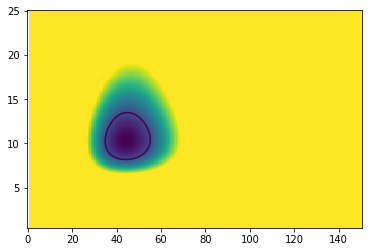

In [315]:
plt.figure()
plt.pcolormesh(N0_vec, t12_vec, 2*nlls[0].T, vmin=0, vmax=10)
cs = plt.contour(N0_vec, t12_vec, 2*nlls[0].T, levels=[2.3])
countour_vals = cs.collections[0].get_paths()[0].vertices

In [316]:
from scipy.stats import lognorm

def gauss(x, A, mu, sig):
    return A*np.exp(-(x-mu)**2/(2*sig**2))

def multigauss(x, A1, m1, s1, A2, m2, s2, sh):
    return gauss(x, A1, m1, s1) + A2*lognorm.pdf((x-m2)/s2, sh)

/var/folders/sz/h29lm_2j53v8vmw0zm_6hxqm0000gn/T/ipykernel_16765/1201209986.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  inset_ax.set_xticklabels(['2.0', '', '3.0', '', '4.0', '', '5.0'])


best fit is:  [44.49760765550239, 10.34924623115578, array([43.77990431]), array([8.8718593]), array([44.49760766]), array([12.1959799])]


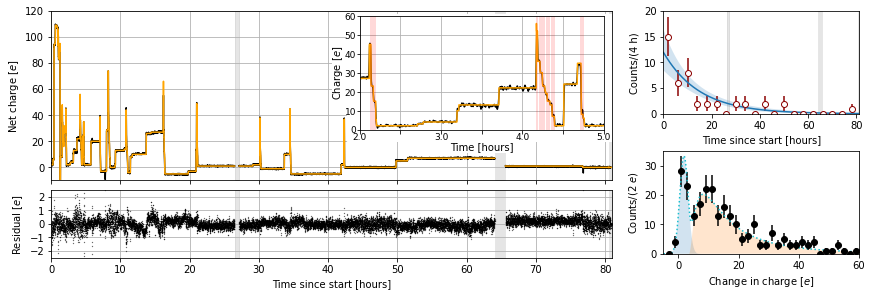

In [350]:
importlib.reload(bu)
recal = 1
init_charge = 10
fig = plt.figure(layout='constrained', figsize=(12, 4))
subfigs = fig.subfigures(1, 2, wspace=0.02, width_ratios=[2.5,1], hspace=0)
n_resamp = 2

axsLeft = subfigs[0].subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [2.5, 1], 'hspace': 0, 'wspace': 0})
#plt.subplot(2,1,1)
#plt.plot(corr_vec[1:,1]/cal_fac*recal, '-')
t12 = 10.6
xv1, xv2 = 0, 81 #time_vals[-1]
time_vals = time_hours[1:]
#diff_vec = np.gradient(corr_vec[1:,corr_idx]/cal_fac)
#b, a = sig.butter(3, 0.000101, btype='high')
#diff_vec = sig.filtfilt(b, a, diff_vec)
#filt_vec = np.cumsum(diff_vec) + init_charge
filt_vec = corr_vec[1:,corr_idx]/cal_fac
filt_vec2 = gaussian_filter1d(filt_vec,n_resamp)

samps=2
for tt in dead_period_edges:
    st = np.argmin(np.abs(time_hours[1:]-tt[0]))-samps
    filt_vec2[st:(st+2*samps+1)] = np.nan
    running_charge[st:(st+2*samps+1)] = np.nan

axsLeft[0].plot(time_vals, filt_vec2, 'k-', label="Correlation", rasterized=True)
axsLeft[0].plot(time_vals, running_charge, '-', color='orange', label="Recon. charge", rasterized=True)
plt.sca(axsLeft[0])
plt.grid(True)
plt.ylim(-10,120)
bu.fill_dps(dead_period_edges)
#bu.fill_dps(lamp_period_edges, 'black', lab="UV lamp")
#bu.fill_dps(filament_period_edges, 'red', lab="Filament", line=True)
plt.ylabel("Net charge [$e$]")
plt.xlim(xv1, xv2)

inset_ax = axsLeft[0].inset_axes([0.55, 0.3, 0.435, 0.67])
inset_ax.plot(time_vals, filt_vec2, 'k-', label="Correlation", rasterized=True)
inset_ax.plot(time_vals, running_charge, '-', color='orange', label="Recon. charge")
inset_ax.set_xlim(2,5)
inset_ax.set_ylim(0,60)
bu.fill_dps(filament_period_edges, 'red', lab="Filament", ax=inset_ax, line=True)
inset_ax.tick_params(axis='x', pad=0, labelsize=9)
inset_ax.tick_params(axis='y', pad=0, labelsize=9)
inset_ax.xaxis.labelpad = 0
inset_ax.yaxis.labelpad = 0
inset_ax.grid(True)
inset_ax.set_xlabel("Time [hours]")
inset_ax.set_ylabel("Charge [$e$]")
inset_ax.set_xticklabels(['2.0', '', '3.0', '', '4.0', '', '5.0'])
rect = Rectangle((0.527,0.23), 0.55, 0.75, transform=axsLeft[0].transAxes, color='white', zorder=3)
axsLeft[0].add_patch(rect)

rect = Rectangle((0.7,0.17), 0.15, 0.1, transform=axsLeft[0].transAxes, color='white', zorder=3)
axsLeft[0].add_patch(rect)

rect = Rectangle((0.5,0.45), 0.05, 0.35, transform=axsLeft[0].transAxes, color='white', zorder=3)
axsLeft[0].add_patch(rect)

plt.sca(axsLeft[1])
resid = running_charge-filt_vec
#b,a = sig.butter(3, 0.01, btype='low')
#resid_filt = sig.filtfilt(b, a, resid)
resid2= gaussian_filter1d(resid,n_resamp)
axsLeft[1].plot(time_vals[::n_resamp], resid2[::n_resamp], 'k.', ms=0.5, rasterized=True)
plt.grid(True)
plt.xlim(xv1, xv2)
plt.ylabel("Residual [$e$]")
plt.ylim(-2.5,2.5)
bu.fill_dps(dead_period_edges)
plt.gca().set_yticks([-2,-1,0,1,2])
plt.xlabel("Time since start [hours]")

axsMid = subfigs[1].subplots(2, 1)
plt.sca(axsMid[0])
#plt.subplot(1,2,j+1)
plt.errorbar( bc_for_plot, hh_for_plot, yerr=np.sqrt(hh_for_plot), fmt='o', 
             markeredgecolor='darkred', color='darkred', markerfacecolor='white', label="Data")
curr_bp = params_from_profile[j]
xx = np.linspace(0,time_hours[-1],1000)

countour_mat = np.zeros((len(countour_vals), len(xx)))
for k,vert in enumerate(countour_vals):
    countour_mat[k,:] = np.log(2)*bin_length*vert[0]/vert[1] * 0.5**(xx/vert[1])

yy = np.log(2)*bin_length*curr_bp[0]/curr_bp[1] * 0.5**(xx/curr_bp[1])
#ylo = np.log(2)*bin_length*curr_bp[2]/curr_bp[3] * 0.5**(xx/curr_bp[3])
#yhi = np.log(2)*bin_length*curr_bp[4]/curr_bp[5] * 0.5**(xx/curr_bp[5])
ylo = np.min(countour_mat, axis=0)
yhi = np.max(countour_mat, axis=0)
print("best fit is: ", curr_bp )

plt.plot(xx, yy, color='tab:blue', label="Fit +/- 1$\sigma$")
plt.fill_between(xx, ylo, yhi, color='tab:blue', alpha=0.2, edgecolor=None)
#plt.errorbar( bc, hh2, yerr=np.sqrt(hh2), fmt='o', color='orange', markerfacecolor='None', label="Recon $\geq$6$e$")
plt.ylim(0,20)
bu.fill_dps(dead_period_edges)
plt.xlabel("Time since start [hours]")
plt.ylabel("Counts/(%.0f h)"%(bin_length))

plt.xlim(xv1, xv2)
#plt.legend()

#axsRight = subfigs[2].subplots(1, 1)
plt.sca(axsMid[1])
change_data = all_charge_changes
#ymin, ymax = -5, 1.1*np.max(change_data)
binslo = np.arange(-4,20,2)
#binsmid = np.arange(5,20,5)
binshi = np.arange(20,int(1.1*np.max(change_data)),2)

bins = np.hstack((binslo, binshi))
hh, be = np.histogram(change_data, bins=bins) #, range=(ymin,ymax))
bc = be[:-1] + np.diff(be)/2
bin_width = np.diff(be)

gpts = bc < 100
spars = [33.3,  1.83,  1.38, 30.8,  3.45, 11.9, 0.956]
bp, bcov = opt.curve_fit(multigauss, bc[gpts], hh[gpts], sigma=sig[gpts], p0=spars)
xx = np.linspace(-5, 100, 1000)

bp_ln = bp.copy()
bp_ln[0] = 0
plt.errorbar(bc, hh, yerr=np.sqrt(hh), fmt='ko')
plt.plot(xx, multigauss(xx, *bp), ':', color='tab:cyan')
plt.fill_between(xx, np.zeros_like(xx), gauss(xx, *bp[:3]), alpha=0.2)
plt.fill_between(xx, np.zeros_like(xx), multigauss(xx, *bp_ln), alpha=0.2)
plt.xlabel("Change in charge [$e$]")
plt.ylabel("Counts/(2 $e$)")
#plt.gca().set_yscale('log')
#plt.savefig("charge_fig_paper.pdf", dpi=300, bbox_inches='tight')
plt.ylim(0,35)
plt.xlim(-5,60)

plt.show()

In [330]:
print(bp)

[33.30869183  1.82884384  1.37832582 30.75113063  3.45162828 11.86917368
  0.95645101]


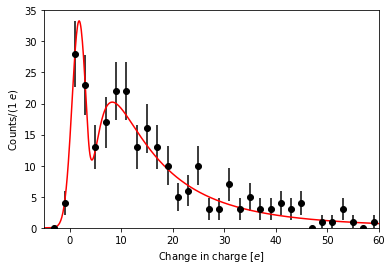

In [ ]:
plt.figure()

sig = np.sqrt(hh)
sig[sig==0] = 1

bp, bcov = opt.curve_fit(multigauss, bc, hh, sigma=sig, p0=[20, 2, 1, 20, 20, 20, 1])

xx = np.linspace(-5, 100, 1000)

plt.errorbar(bc, hh, yerr=np.sqrt(hh), fmt='ko')
plt.plot(xx, multigauss(xx, *bp), 'r-')

plt.xlabel("Change in charge [$e$]")
plt.ylabel("Counts/(1 $e$)")
#plt.gca().set_yscale('log')
#plt.savefig("charge_fig_paper.pdf", dpi=300, bbox_inches='tight')
plt.ylim(0,35)
plt.xlim(-5,60)

plt.show()

In [207]:
#countour_vals[j,:] = np.log(2)*bin_length*vert[0]/vert[1] * 0.5**(xx/vert[1])
np.shape(np.log(2)*bin_length*vert[0]/vert[1] * 0.5**(xx/vert[1]))
np.shape(countour_vals)

(133, 2)

Now the figure for the impulse

In [5]:
import pickle

file_label = "20231030"
code_path = "/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/decay_analysis"
data_dir = os.path.join(code_path, "data", file_label)
with open(data_dir+"/pulse_plot_%s.pkl"%file_label, 'rb') as f:
    pulse_data = pickle.load(f)

for k in pulse_data.keys():
    print(k)
    exec("%s = pulse_data['%s']"%(k,k))


template_dict_fit
noise_dict_3D
cal_fac_fine
cal_fac_coarse
volts_per_meters
calibrated_OF_amps_from_fit
filt_bins_offset
data_list


/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/decay_analysis/bead_utils.py:2570: RuntimeWarning: invalid value encountered in sqrt
  corr_data = np.sqrt(sp.filtfilt(b_lp, a_lp, corr_data**2))
/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/decay_analysis/bead_utils.py:2572: RuntimeWarning: invalid value encountered in sqrt
  corr_data = np.sqrt(sp.filtfilt(b_lpz, a_lpz, corr_data**2))
/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/decay_analysis/bead_utils.py:2570: RuntimeWarning: invalid value encountered in sqrt
  corr_data = np.sqrt(sp.filtfilt(b_lp, a_lp, corr_data**2))
/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/decay_analysis/bead_utils.py:2572: RuntimeWarning: invalid value encountered in sqrt
  corr_data = np.sqrt(sp.filtfilt(b_lpz, a_lpz, corr_data**2))


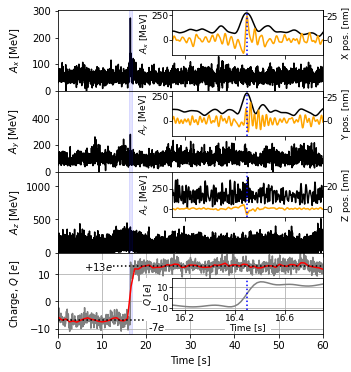

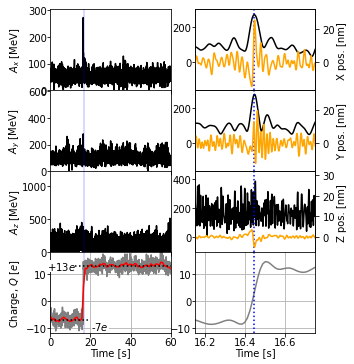

In [6]:
importlib.reload(bu)
cfile = 271 ## from 10/30/2023
cdat, attr, _ = bu.get_data(data_list[cfile])
yup = 75
xrange = [-1, -1]
charge_range = [-1, -1]
fig = plt.figure(figsize=(4,5))
omega0, gamma = 2*np.pi*37.8, 2*np.pi*4.2

_ = bu.plot_impulse_with_recon_3D(cdat, attr, template_dict_fit, noise_dict_3D, cal_facs=[cal_fac_fine, cal_fac_coarse], 
                                        amp_cal_facs=[volts_per_meters, calibrated_OF_amps_from_fit],
                                        filt_time_offset = filt_bins_offset, drive_idx=8, figout=fig,
                                        xrange=xrange, charge_range=charge_range, do_lowpass=True, ylim_init=[0,80],
                                        toffset = 35, tmax=60, subtract_sine_step=False, res_pars=[omega0, gamma], filt_charge_data=True,
                                        field_cal_fac=0.8, ylim2_scale=4.75, paper_plot=True, rasterized=True)

plt.savefig("pulse_fig_paper.pdf", bbox_inches='tight', dpi=300)

fig = plt.figure(figsize=(4,5))

_ = bu.plot_impulse_with_recon_3D(cdat, attr, template_dict_fit, noise_dict_3D, cal_facs=[cal_fac_fine, cal_fac_coarse], 
                                        amp_cal_facs=[volts_per_meters, calibrated_OF_amps_from_fit],
                                        filt_time_offset = filt_bins_offset, drive_idx=8, figout=fig,
                                        xrange=xrange, charge_range=charge_range, do_lowpass=True, ylim_init=[0,80],
                                        toffset = 35, tmax=60, subtract_sine_step=False, res_pars=[omega0, gamma], filt_charge_data=True,
                                        field_cal_fac=0.8, ylim2_scale=4.75, paper_plot=False, rasterized=True)

plt.savefig("pulse_fig_paper_2col.pdf", bbox_inches='tight', dpi=300)